This notebook creates a very simple deep learning model as a first approach to solve captcha image to text problem <br/>


The model performs a <b>multi-label & multi-class classification</b> <br/>
It has <b>5 softmax output layers</b> (each of them classifies one alphanumeric character of the captcha images) <br/>
To compute the loss function, categorical cross-entropy is used for each output layer and the results are averaged <br/>
The input layer has a tensor of size nx50x200x1 where n is the batch size <br/>
<b>Convolutional, pooling, batch normalization, dropout and dense</b> layers are used to define the inner topology of the network

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import keras
import keras.backend as K
from keras.layers import *
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import *
from sklearn.model_selection import train_test_split
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

Using TensorFlow backend.


Load the preprocessed dataset

In [2]:
data = np.load('/floyd/home/processed-data.npz')

In [3]:
X, y = data['X'], data['y']

In [4]:
X.shape

(1070, 50, 200, 1)

In [5]:
y.shape

(5, 36, 1070)

In [6]:
y = y.swapaxes(0,2).swapaxes(1, 2)

In [7]:
y.shape

(1070, 5, 36)

In [8]:
np.count_nonzero(y[:, 0, :])

1070

Now we build the model. We are going to use convolutional, pooling, batch normalization and dropout fro the first layers <br/>

In [11]:
K.clear_session()
t_in = Input(shape=(50, 200, 1), name='input')

# CONV + RELU + BN + POOLING + DROPOUT
t_conv = Conv2D(32, (3, 3), activation='relu', name='conv1')(t_in)
t_norm = BatchNormalization(name='bn1')(t_conv)
t_pool = MaxPool2D((2, 2), name='pool1')(t_norm)
t_drop = Dropout(0.25, name='drop1')(t_pool)

# CONV + RELU + BN + POOLING + DROPOUT
t_conv2 = Conv2D(16, (3, 3), activation='relu', name='conv2')(t_drop)
t_norm2 = BatchNormalization(name='bn2')(t_conv2)
t_pool2 = MaxPool2D((2, 2), name='pool2')(t_norm2)
t_drop2 = Dropout(0.25, name='drop2')(t_pool2)

# CONV + RELU + BN + POOLING + DROPOUT + FLATTEN
t_conv3 = Conv2D(8, (3, 3), activation='relu', name='conv3')(t_drop2)
t_norm3 = BatchNormalization(name='bn3')(t_conv3)
t_drop3 = Dropout(0.25, name='drop3')(t_norm3)

Now for each of the 5 outputs (1 per character in the text) we create a branch on the model <br/>
Each branch will have a dense layer followed by softmax

In [18]:
t_flatten = Flatten(name='flatten')(t_drop2)

In [19]:
t_dense = [Dense(64, activation='relu',
                 kernel_initializer='random_uniform', name='dense2-{}'.format(k))(t_flatten)
           for k in range(0, 5)]

In [20]:
t_dense[0]

<tf.Tensor 'dense2-0_1/Relu:0' shape=(?, 64) dtype=float32>

In [21]:
t_soft = [Dense(36, activation='softmax', kernel_initializer='random_uniform',
               name='char_{}'.format(k))(t_dense[k])
         for k in range(0, 5)]

In [22]:
t_soft[0]

<tf.Tensor 'char_0_1/Softmax:0' shape=(?, 36) dtype=float32>

In [23]:
model = Model(inputs=[t_in], outputs=t_soft)

In [24]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 50, 200, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 198, 32)  320         input[0][0]                      
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 198, 32)  128         conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 24, 99, 32)   0           bn1[0][0]                        
__________________________________________________________________________________________________
drop1 (Dro

Now we compile the model

In [42]:
model.compile(optimizer=RMSprop(), loss=['categorical_crossentropy'] * 5)

In [43]:
out = model.predict(X[0:1, :, :, 0].reshape([1, 50, 200, 1]))
len(out), out[0].shape

(5, (1, 36))

Split the data into training & test sets

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=13)

In [45]:
X_train.shape, X_test.shape

((909, 50, 200, 1), (161, 50, 200, 1))

In [46]:
y_train.shape, y_test.shape

((909, 5, 36), (161, 5, 36))

Train the model

In [47]:
history = model.fit(X_train, [y_train[:, k, :] for k in range(0, 5)],
                    epochs=5, batch_size=2, verbose=True,
                    callbacks=[])

Epoch 1/5
909/909 [==============================] - 32s 35ms/step - loss: 27.2271 - char_0_loss: 2.9555 - char_1_loss: 2.9592 - char_2_loss: 2.9578 - char_3_loss: 2.9636 - char_4_loss: 15.3911
Epoch 2/5
909/909 [==============================] - 30s 33ms/step - loss: 27.2004 - char_0_loss: 2.9550 - char_1_loss: 2.9526 - char_2_loss: 2.9513 - char_3_loss: 2.9503 - char_4_loss: 15.3911
Epoch 3/5
909/909 [==============================] - 31s 34ms/step - loss: 27.1833 - char_0_loss: 2.9544 - char_1_loss: 2.9461 - char_2_loss: 2.9413 - char_3_loss: 2.9503 - char_4_loss: 15.3911
Epoch 4/5
909/909 [==============================] - 31s 34ms/step - loss: 15.2124 - char_0_loss: 2.9604 - char_1_loss: 2.9576 - char_2_loss: 2.9464 - char_3_loss: 2.9506 - char_4_loss: 3.3974
Epoch 5/5
909/909 [==============================] - 31s 34ms/step - loss: 15.3663 - char_0_loss: 2.9460 - char_1_loss: 2.9423 - char_2_loss: 2.9339 - char_3_loss: 2.9516 - char_4_loss: 3.5925


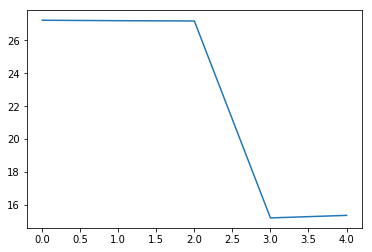

In [63]:
plt.plot(history.history['loss'])

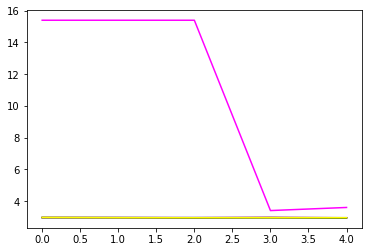

In [64]:
plt.plot(history.history['char_0_loss'], color='blue')
plt.plot(history.history['char_1_loss'], color='red')
plt.plot(history.history['char_2_loss'], color='green')
plt.plot(history.history['char_3_loss'], color='yellow')
plt.plot(history.history['char_4_loss'], color='magenta')

Evaluate the model on test

In [50]:
y_test_pred_labels = np.stack(model.predict(X_test)).swapaxes(0, 1).argmax(axis=2)

In [51]:
y_test_pred_labels.shape

(161, 5)

In [52]:
y_test_pred_labels[0,:]

array([13, 13, 13, 13, 28])

In [53]:
y_test_labels = y_test.argmax(axis=2)

In [54]:
y_test_labels[0,:]

array([31, 22,  3,  3, 22])

For each prediction, we calculate a score that will be proportional to the number of characters matched with the captcha text correctly <br/>
The global score will be an average of such values

In [62]:
np.mean(np.mean(y_test_pred_labels == y_test_labels, axis=1))

0.09689440993788821

Also we can calculate the number of predictions that fully matches with the captcha texts and divide it by the number of predictions

In [69]:
np.mean(np.all(y_test_pred_labels == y_test_labels, axis=1))

0.0

This model doesnt solve our classification problem very good